In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
sys.path.append('/global/homes/j/jpiat/hodpy/')

from hodpy.mass_function import MassFunctionAbacus
from hodpy.catalogue import Catalogue
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from hodpy.cosmology import CosmologyAbacus
cosmo = CosmologyAbacus(0)  #c000 cosmology

In [30]:
def volume(z):
    
    D_min = cosmo.comoving_distance(np.min(z))
    D_max = cosmo.comoving_distance(np.max(z))
    
    vol_shell = 4*np.pi*(D_max**3-D_min**3)/3
    
    vol_lightcone = vol_shell/8  # octant of the sky
    
    return vol_lightcone



def mass_function(masses,z):

    mass_min = 2*10**11
    mass_max = 4*10**14
    n_bins = 50
    
    bins = np.logspace(np.log10(mass_min),np.log10(mass_max),n_bins+1)
    dlogM = (np.log10(mass_max) - np.log10(mass_min))/n_bins
    
    M = (bins[1:]+bins[:-1])/2

    dN, _ = np.histogram(masses, bins = bins)
    
    vol = volume(z)
    
    mass_func = dN/dlogM/vol
    
    return mass_func, M



def mf_snapshot(zs, log_mass):
    
    # plot fit to AbacusSummit halo mass function at a few different redshifts
    mf = MassFunctionAbacus(cosmo=0)
    
    #log_mass = np.arange(10,16,0.01) #halo mass bins
    
    z = np.ones(len(log_mass))*zs
    
    n = mf.number_density(log_mass, z)
        
    return n, log_mass

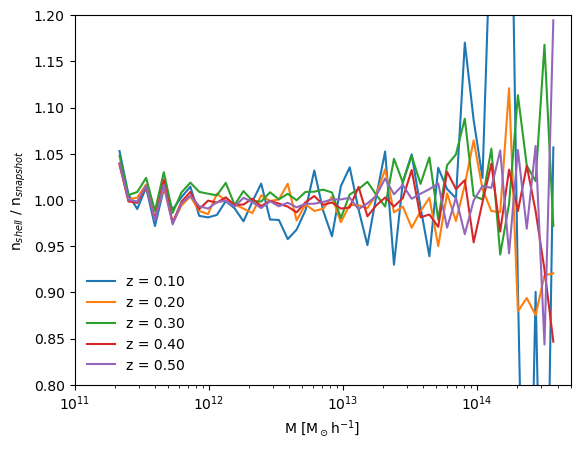

In [41]:
plt.figure()
plt.xlabel(r'M [M$_\odot$h$^{-1}$]')
#plt.ylabel(r'n(M) [h$^3$ Mpc$^{-3}$ log(M)$^{-1}$]')
plt.ylabel(r'n$_{shell}$ / n$_{snapshot}$')
plt.xlim(1e11,5e14)
plt.ylim(0.8,1.2)
plt.xscale('log')

ax = plt.gca()

z_shell = np.arange(0.1,0.55,0.05)
z_shell = np.arange(0.1,0.6,0.1)


def position_cut(pos):
    
    x, y, z = pos[:,0], pos[:,1], pos[:,2]
    
    cut = (x>-990)*(y>-990)*(z>-990)
    
    new_pos = np.zeros((len(cut[cut == True]),3))
    
    new_pos[:,0], new_pos[:,1], new_pos[:,2]  = x[cut], y[cut], z[cut]
    
    return new_pos, cut


for z in z_shell:

    halo_lc_path = "/global/cfs/cdirs/desi/cosmosim/Abacus/halo_light_cones/AbacusSummit_base_c000_ph000/z%.3f/lc_halo_info.asdf"%z
    cat = CompaSOHaloCatalog(halo_lc_path, cleaned=True, fields=['N_interp','pos_avg','redshift_interp'])

    Mpart = cat.header['ParticleMassHMsun']
    
    halo_pos, cut_sky = position_cut(cat.halos['pos_avg'])
    halo_masses = cat.halos['N_interp'][cut_sky]*Mpart
    halo_z = cat.halos['redshift_interp'][cut_sky]
    
    n, M = mass_function(halo_masses,halo_z)
    
    zs = np.median(halo_z)
    n_snap, logM_snap = mf_snapshot(zs, np.log10(M))
    
    mask = M > Mpart*100

    color = next(ax._get_lines.prop_cycler)['color']
    #plt.loglog(M[mask],n[mask], c=color, label='z = {:.2f}'.format(z))
    #plt.loglog(10**logM_snap, n_snap, c=color, ls = '--')
    
    plt.plot(M, n[mask] / n_snap[mask], c=color, label='z = {:.2f}'.format(z))

plt.legend(loc='lower left').draw_frame(False)

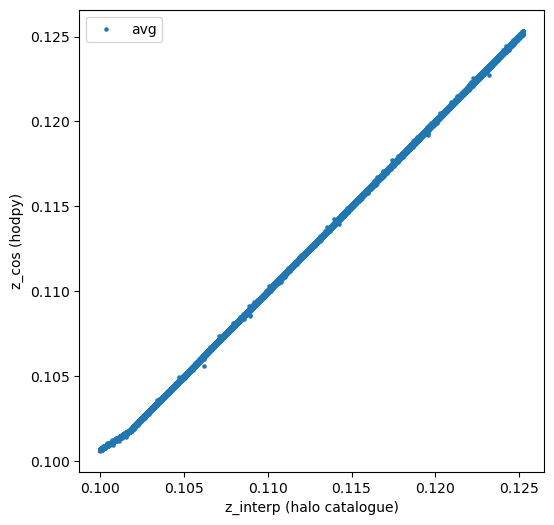

In [22]:
lc_cat = Catalogue(cosmo)

z_shell = 0.1

plt.figure(figsize=(6,6))
plt.xlabel('z_interp (halo catalogue)')
plt.ylabel('z_cos (hodpy)')

halo_lc_path = "/global/cfs/cdirs/desi/cosmosim/Abacus/halo_light_cones/AbacusSummit_base_c000_ph000/z%.3f/lc_halo_info.asdf"%z_shell
cat = CompaSOHaloCatalog(halo_lc_path, cleaned=True, fields=['N_interp','pos_interp','pos_avg','redshift_interp'])

halos = cat.halos
filled = (halos['N_interp']>0)&(halos['pos_avg'][:,0]<0)
halos = halos[filled]

origin = -990      
halos = halos[np.all(halos['pos_avg']>origin,axis=1)]
halos_pos = halos['pos_avg']-origin     # origin is taken at -990,-990,-990 in halo

z_interp = halos['redshift_interp']

ra,dec,z_cos_avg = lc_cat.pos3d_to_equatorial(halos_pos)         
#ra,dec,z_cos_interp = lc_cat.pos3d_to_equatorial(halos['pos_interp']+origin)

plt.scatter(z_interp, z_cos_avg, label='avg',s=5)
#plt.scatter(z_interp, z_cos_interp, label='interp',s=5)
plt.legend();

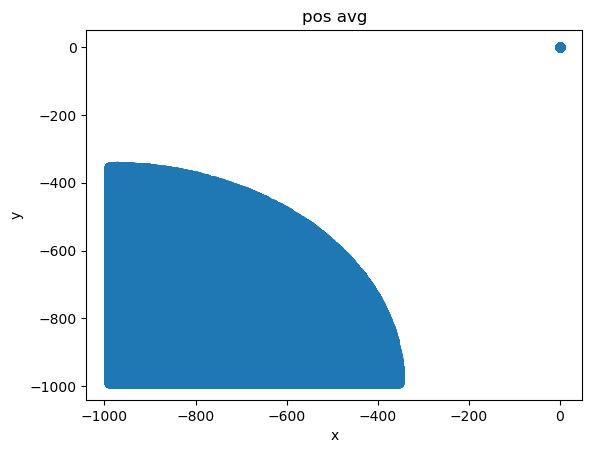

In [41]:
plt.title('pos avg')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(halos['pos_avg'][:,0], halos['pos_avg'][:,1]);